In [1]:
import torch
import numpy as np
import torch.nn as nn
import moviepy.editor as mpy
import matplotlib.pyplot as plt

from tqdm import tqdm
from mayavi import mlab

mlab.init_notebook(width=500, height=500, backend="png")

Notebook initialized with png backend.


In [2]:
colormaps = [
    'Accent','Blues','BrBG','BuGn','BuPu','CMRmap','Dark2','GnBu','Greens','Greys','OrRd','Oranges','PRGn',
    'Paired','Pastel1','Pastel2','PiYG','PuBu','PuBuGn','PuOr','PuRd','Purples','RdBu','RdGy','RdPu','RdYlBu',
    'RdYlGn','Reds','Set1','Set2','Set3','Spectral','Vega10','Vega20','Vega20b','Vega20c','Wistia','YlGn','YlGnBu',
    'YlOrBr','YlOrRd','afmhot','autumn','binary','black-white','blue-red','bone','brg','bwr','cool','coolwarm',
    'copper','cubehelix','file','gist_earth','gist_gray','gist_heat','gist_ncar','gist_rainbow','gist_stern',
    'gist_yarg','gnuplot','gnuplot2','gray','hot','hsv','inferno','jet','magma','nipy_spectral','ocean','pink',
    'plasma','rainbow','seismic','spectral','spring','summer','terrain','viridis','winter'
]

## 1. Neural Network Design
----

In [6]:
class LinearBlock(nn.Module):
    def __init__(self, din, dout, act='relu', lim=2):
        """
        Args:
            din (int): input dimension for the layer
            dout (int): output dimension for the layer
            act (str): string of pytorch activation function
            lim (float): upper and lower limit of initialization
                for the linear layer weights and biases
        """
        super().__init__()
        self.lin = nn.Linear(din, dout)
        self.act = self._get_activation_fn(act)
        
        # important for quality of results
        nn.init.uniform_(self.lin.weight, -lim, lim)
            
    def _get_activation_fn(self, name):
        """Gets the activation function callable
        
        Args:
            name (str): name of the pytorch function
            
        Returns:
            callable: activation function
        """
        try:
            return eval(f"torch.{name}")
        except:
            return eval(f"F.{name}")
    
    def forward(self, x):
        """Forward pass
        
        Args:
            x (torch.Tensor): layer input of shape (*, din)
            
        Returns:
            torch.Tensor: layer output of shape (*, dout)
        """
        return self.act(self.lin(x))
    

class PlanetMLP(nn.Module):
    
    def __init__(
        self, 
        in_dim, 
        layers,
        radius=10,
        activations=None, 
        zdim=16, 
        ffeats=-1,
        ffscale=1, 
        final_activation='sigmoid',
        init_limit=5,
        noise_decay=0.25,
        noise_scale=1.5,
        min_delta=0.5
    ):
        """
        Args:
            in_dim (int): input dimension of data
            layers (Iterable[int]): list of the number of nodes per hidden layer
            radius (float): radius of the planet
            activations (Iterable[str]): list of activations for each hidden layer
            zdim (int): latent dimension
            ffeats (int): number of fourier features, must be greater than 0 to use
            ffscale (float): scale of fourier feature mapping (higher -> high frequencies)
            scale (float): scale of latent features (zoom)
            final_activation (Union[str, callable]): Final activation to apply to NN output
            init_limit (float): Upper and lower limit of init values for layer weights
        """
        super().__init__()
        self.layers = layers
        self.zdim = zdim
        self.init_limit = init_limit
        self.ffeats = ffeats
        self.acts = activations
        self.in_dim = in_dim
        self.radius = radius
        self.noise_decay = noise_decay
        self.noise_scale = noise_scale
        self.min_delta = min_delta
        
        # fourier features initialization
        if ffeats > 0:
            self.B = torch.randn(size=(self.in_dim, ffeats)) * ffscale
            self.in_dim = 2 * ffeats
        
        # define hidden layer dimensions
        self.hidden = list(zip(layers, layers[1:]))
        
        # activation functions
        if self.acts is None:
            self.acts = ['tanh'] * len(layers)
        else:
            assert len(self.acts) == len(layers), (
                f"num activation functions {len(self.acts)} != num layers {len(layers)}"
            )
            
        self.init_act = self._get_activation_fn(self.acts[0])
        self.final_act = (
            final_activation if hasattr(final_activation, '__call__')
            else (  # if it's not a str or callable, default to identity
                self._get_activation_fn(final_activation) if isinstance(final_activation, str)
                else lambda x: x
            )
        )
            
        # initialize layers
        self.xyzlayer = nn.Linear(self.in_dim, layers[0], bias=False)
        self.latent_layer = nn.Linear(zdim, layers[0])
        self.mlp = self._create_layers()
        
        print(f"\n{'-'*30} [ARCHITECTURE] {'-'*30}\n{self}{'-'*75}")
        
    def _get_activation_fn(self, name):
        """Gets the activation function callable
        
        Args:
            name (str): name of the pytorch function
            
        Returns:
            callable: activation function
        """
        try:
            return eval(f"torch.{name}")
        except:
            return eval(f"F.{name}")
        
    def _create_layers(self):
        """Initialize the hidden layers of NN
        
        Returns:
            nn.Sequential: NN module for the hidden layers
        """
        layers = [
            LinearBlock(i, o, a, lim=self.init_limit) 
            for (i, o), a in zip(self.hidden, self.acts[1:])
        ]   
        layers.append(nn.Linear(self.layers[-1], 1))
        return nn.Sequential(*layers)

    def _fourier_feature_transform(self, x):
        """Randomly lifts inputs into a fourier basis
        
        Refer to - https://arxiv.org/abs/2006.10739
        
        Args:
            x (torch.Tensor): input, must be of shape (*, in_dims)
            
        Returns:
            torch.Tensor: lifted input features of shape (*, # of fourier features)
        """
        x_proj = 2 * np.pi * x @ self.B 
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    
    def _latent_code(self, H, W, dist_param=1.0):
        """Generate latent code for inference
        
        Args:
            H (int): size of domain along dim 0
            W (int): size of domain along dim 1
            dist_param (float[Optional]): parameter for the latent distribution
            
        Returns:
            torch.Tensor: latent code in a grid of shape (H, W, zdim)
        """
        return torch.FloatTensor(1, self.zdim).normal_(dist_param).repeat(H, W, 1)
    
    def _postprocess(self, topo_deltas):
        """Compute topographic map. This function can be modified freely.
        
        Args:
            topo_deltas (torch.Tensor): output of the layers of shape (H, W, 1)
            
        Returns:
            np.ndarray: actual height map of the planet of shape (H, W)
        """
        base_noise = topo_deltas.detach().numpy().squeeze()
        delta = (1 - np.abs(base_noise))**2
        # randomly choose to give spiky (mountainous) vs flat (plateau-y) terrain
        # ... non-determinism makes life interesting
        if np.random.rand() > 1/2:  # spiky
            terrain = delta * (delta > self.min_delta)
        else:  # flat
            terrain = self.min_delta * (delta > self.min_delta) + delta * (delta <= self.min_delta)
        return terrain

    
    def forward(self, x, scales=1, latent=None):
        """Generate topography for the planet
        
        Args:
            x (torch.Tensor): domain for the sphere in Euclidean coordinates of shape (H,W,3)
                where H & W is the resolution of the phi & theta space
            latent (torch.Tensor[Optional]): latent code for generation of shape (H,W,zdim)
                If none provided, a default code will be generated.
            multiplicative (bool[Optional]): multiply the first layer output with the latent
                layer output, otherwise add latent layer output (default: False)
            scale (float[Optional]): scale of latent features (zooming effect)
                
        Returns:
            torch.Tensor: topographic (height) map of shape (H,W)
        """
        if latent is None:
            latent = self._latent_code(*x.shape[:2])
            
        if self.ffeats > 0:
            x = self._fourier_feature_transform(x)

        topo_map = torch.zeros(x.shape[:2])
        for i in range(scales):
            coords = self.xyzlayer((self.noise_scale**(i+1))*x)
            coords += self.latent_layer(latent)
            coords = self.init_act(coords)
            coords = self.mlp(coords)
            deltas = self.final_act(coords)
            topo_map += ((self.noise_decay ** (i+1)) * self._postprocess(deltas))
            
        return topo_map + self.radius
            

## 2. Procedurally generating the planets
----

In [7]:
# Defining the domain
resolution = 512
theta = np.linspace(0, 2*np.pi, resolution)   
phi = np.linspace(0, np.pi, resolution)       
phi, theta = np.meshgrid(phi, theta)  

#### 2.1 Initializing the neural network

In [16]:
"""For reference, possible activations:

    softplus, tanh, cos, sigmoid, mish, logsigmoid
    
"""
mlp = PlanetMLP(
    radius=10,
    in_dim=3, 
    layers=[64] * 3, 
    activations=['sigmoid', 'sin', 'tanh'],
    ffeats=-1, 
    ffscale=1, 
    zdim=16,
    final_activation='tanh',
    init_limit=3,
    noise_decay=0.5,
    noise_scale=1.5
)


------------------------------ [ARCHITECTURE] ------------------------------
PlanetMLP(
  (xyzlayer): Linear(in_features=3, out_features=64, bias=False)
  (latent_layer): Linear(in_features=16, out_features=64, bias=True)
  (mlp): Sequential(
    (0): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)---------------------------------------------------------------------------


In [20]:
# center the domain
x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

# inference (for now dont manually pass in latent code)
grid = torch.from_numpy(np.stack([x, y, z], axis=-1)).float()
height_field = mlp(grid, scales=15)

#### 2.2 Visualization of the ($\phi$, $\theta$) manifold

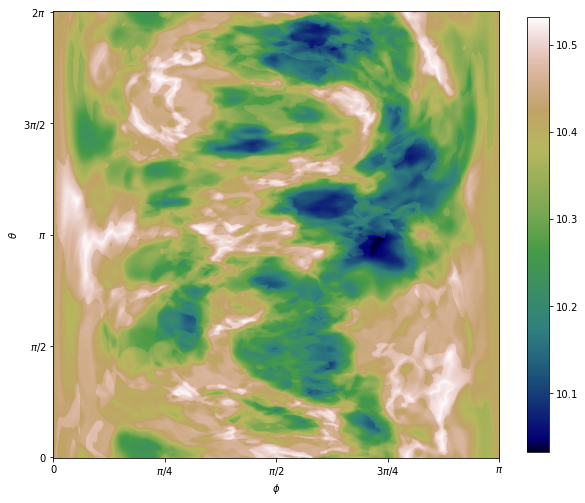

In [21]:
# visualize
plt.figure(figsize=(10, 10))
plt.xlabel("$\phi$")
plt.ylabel(r"$\theta$")
plt.xticks(np.linspace(0, height_field.shape[1]-1, 5), [0, '$\pi$/4', '$\pi/2$', '$3\pi/4$', '$\pi$'])
plt.yticks(np.linspace(0, height_field.shape[0]-1, 5), ['2$\pi$', '$3\pi/2$', '$\pi$', '$\pi/2$', 0])
plt.imshow(height_field, cmap='gist_earth')
plt.colorbar(shrink=0.8);

## 3. Visualize on a sphere
---


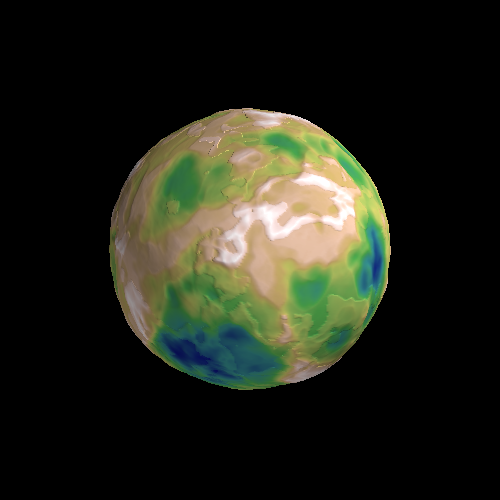

: 

In [22]:
x = height_field * np.sin(phi)*np.cos(theta)
y = height_field * np.sin(phi)*np.sin(theta)
z = height_field * np.cos(phi)

mlab.clf()
fig = mlab.figure(size=(500, 500), bgcolor=(0,0,0))

mlab.mesh(x, y, z, scalars=height_field, colormap='gist_earth', figure=fig)

## 4. Animate the rotation
----

In [335]:
duration = 10 # duration of the animation in seconds (it will loop)

mlab.clf()
fig = mlab.figure(size=(500, 500), bgcolor=(0,0,0))

s = mlab.mesh(x, y, z, scalars=height_field, colormap='terrain', figure=fig)

def make_frame(t):
    mlab.view(azimuth= 360 * t/duration, distance=mlp.radius * 7.5) # camera angle
    return mlab.screenshot(antialiased=True)

animation = mpy.VideoClip(make_frame, duration=duration)
animation.write_gif("videos/rotation.gif", fps=30)

t:   1%|          | 2/300 [00:00<00:14, 19.99it/s, now=None]

MoviePy - Building file videos/rotation.gif with imageio.


## 5. Interpolating worlds
----

In [337]:
# define the two neural networks to interpolate between
z_world_interp1 = torch.FloatTensor(1, 32).normal_(2).repeat(*grid.shape[:2], 1)
z_world_interp2 = torch.FloatTensor(1, 32).normal_(1).repeat(*grid.shape[:2], 1)

mlp1 = PlanetMLP(
    radius=8,
    in_dim=3, 
    layers=[64] * 2, 
    activations=['cos', 'tanh'],
    ffeats=8,
    ffscale=2,
    zdim=32,
    final_activation='tanh',
    init_limit=4
)

mlp2 = PlanetMLP(
    radius=10,
    in_dim=3, 
    layers=[64] * 3, 
    activations=['sigmoid', 'sin', 'sigmoid'],
    ffeats=8, 
    ffscale=1, 
    zdim=32,
    final_activation='tanh',
    init_limit=2
)

# animate
mlab.clf()
duration = 5
fig = mlab.figure(size=(500, 500), bgcolor=(0,0,0))

hfield = mlp1(grid, z_world_interp1)
x = hfield * np.sin(phi)*np.cos(theta)
y = hfield * np.sin(phi)*np.sin(theta)
z = hfield * np.cos(phi)
s = mlab.mesh(x, y, z, scalars=hfield, colormap='gist_earth', figure=fig)

def make_interp_frame(t):
    step = t / duration
    mix = np.sin(np.pi * step)
    hfield = mlp1(grid, z_world_interp1) * (1 - mix) + mlp2(grid, z_world_interp2) * mix

    x = hfield * np.sin(phi)*np.cos(theta)
    y = hfield * np.sin(phi)*np.sin(theta)
    z = hfield * np.cos(phi)
    
    s.mlab_source.set(x=x)
    s.mlab_source.set(y=y)
    s.mlab_source.set(z=z)
    s.mlab_source.set(scalars=hfield)
    
    mlab.view(azimuth= 360 * step, distance=mlp1.radius * 7.5) # camera angle
    return mlab.screenshot(antialiased=True)

animation = mpy.VideoClip(make_interp_frame, duration=duration)
animation.write_gif("videos/world_interpolation.gif", fps=30)


------------------------------ [ARCHITECTURE] ------------------------------
PlanetMLP(
  (xyzlayer): Linear(in_features=16, out_features=64, bias=False)
  (latent_layer): Linear(in_features=32, out_features=64, bias=True)
  (mlp): Sequential(
    (0): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)---------------------------------------------------------------------------

------------------------------ [ARCHITECTURE] ------------------------------
PlanetMLP(
  (xyzlayer): Linear(in_features=16, out_features=64, bias=False)
  (latent_layer): Linear(in_features=32, out_features=64, bias=True)
  (mlp): Sequential(
    (0): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)------------------------------


t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

MoviePy - Building file videos/world_interpolation.gif with imageio.


## 7. Interpolating latents
----

In [350]:
latent1 = torch.FloatTensor(1, 32).normal_(2).repeat(*grid.shape[:2], 1)
latent2 = torch.FloatTensor(1, 32).normal_(4).repeat(*grid.shape[:2], 1)

world = PlanetMLP(
    radius=10,
    in_dim=3, 
    layers=[64] * 3, 
    activations=['cos', 'tanh', 'tanh'],
    ffeats=8, 
    ffscale=2,  
    zdim=32,
    final_activation='tanh',
    init_limit=4
)

mlab.clf()
duration = 5
fig = mlab.figure(size=(500, 500), bgcolor=(0,0,0))

hfield = world(grid, latent1)
x = hfield * np.sin(phi)*np.cos(theta)
y = hfield * np.sin(phi)*np.sin(theta)
z = hfield * np.cos(phi)
s = mlab.mesh(x, y, z, scalars=hfield, colormap='gist_earth', figure=fig)

def make_interp_frame(t):
    step = t / duration
    mix = np.sin(np.pi * step)
    hfield = world(grid, (1 - mix) * latent1 + mix * latent2)
    x = hfield * np.sin(phi)*np.cos(theta)
    y = hfield * np.sin(phi)*np.sin(theta)
    z = hfield * np.cos(phi)
    
    s.mlab_source.set(x=x)
    s.mlab_source.set(y=y)
    s.mlab_source.set(z=z)
    s.mlab_source.set(scalars=hfield)
    
    mlab.view(azimuth= 360 * step, distance=100) # camera angle
    return mlab.screenshot(antialiased=True)

animation = mpy.VideoClip(make_interp_frame, duration=duration)
animation.write_gif("videos/latent_interpolation.gif", fps=30)


------------------------------ [ARCHITECTURE] ------------------------------
PlanetMLP(
  (xyzlayer): Linear(in_features=16, out_features=64, bias=False)
  (latent_layer): Linear(in_features=32, out_features=64, bias=True)
  (mlp): Sequential(
    (0): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)---------------------------------------------------------------------------
(512, 512) (512, 512) (512, 512)



t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

MoviePy - Building file videos/latent_interpolation.gif with imageio.


## 8. Brownian motion planets
----
From this wonderful website: https://www.atmosp.physics.utoronto.ca/~mudryk/old/professional/cupc/index.html

In [358]:
def brownian_planet(iterations, radius=1, std=1e-2, phi_resolution=256, theta_resolution=512):
    """Generates a topographic height map with 2D brownian motion
    
    Args:
        iterations (int): number of iterations to run the simulation for
        mean_radius (float): radius of the planet
        std (float): standard deviation of the brownian noise
        phi_resolution (int): number of points for phi
        theta_resolution (int): number of points for theta
        
    Returns:
        tuple[np.ndarray]: tuple containing grids for phi, theta, & heights (radii)
    """
    domain = np.mgrid[np.pi:0:phi_resolution * 1j, 0:2*np.pi:theta_resolution * 1j]
    phi, theta = domain
    heights = radius * np.ones((phi_resolution, theta_resolution))
    for _ in tqdm(range(iterations), desc="Simulating brownian motion"):
        
        # sample random direction for a cut along the sphere
        theta_ind = np.random.choice(theta_resolution)
        phi_ind = np.random.choice(phi_resolution)
        phi_cut, theta_cut = domain[:, phi_ind, theta_ind]

        # compute inner product between cut and all points in the domain
        innerp = np.sin(phi_cut) * np.sin(phi) * np.cos(theta_cut - theta) \
               + np.cos(phi_cut) * np.cos(phi)
        half = heights[innerp > 0]
        
        # randomly perturb the heights on one side of the cut
        heights[innerp > 0] += (1 - np.abs(std * np.random.randn()))
        
    return phi, theta, heights
    

phi, theta, heights = brownian_planet(
    iterations=5000, 
    radius=10,
    std=5e-3, 
    phi_resolution=256, 
    theta_resolution=512
)

Simulating brownian motion: 100%|██████████| 5000/5000 [00:19<00:00, 255.26it/s]


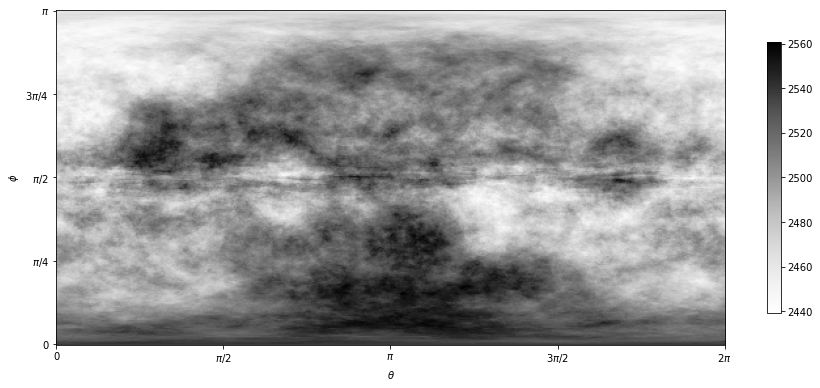

In [363]:
rand_cmap = np.random.choice(colormaps)
plt.figure(figsize=(15,10))
plt.xlabel(r"$\theta$")
plt.ylabel("$\phi$")
plt.yticks(np.linspace(0, heights.shape[0]-1, 5), [0, '$\pi$/4', '$\pi/2$', '$3\pi/4$', '$\pi$'][::-1])
plt.xticks(np.linspace(0, heights.shape[1]-1, 5), ['2$\pi$', '$3\pi/2$', '$\pi$', '$\pi/2$', 0][::-1])
try:
    plt.imshow(heights, cmap=rand_cmap)
except:
    print(f"[WARNING] Unsupported matplotlib color map - {rand_cmap}")
    plt.imshow(heights, cmap='gist_earth')
plt.colorbar(shrink=0.5);


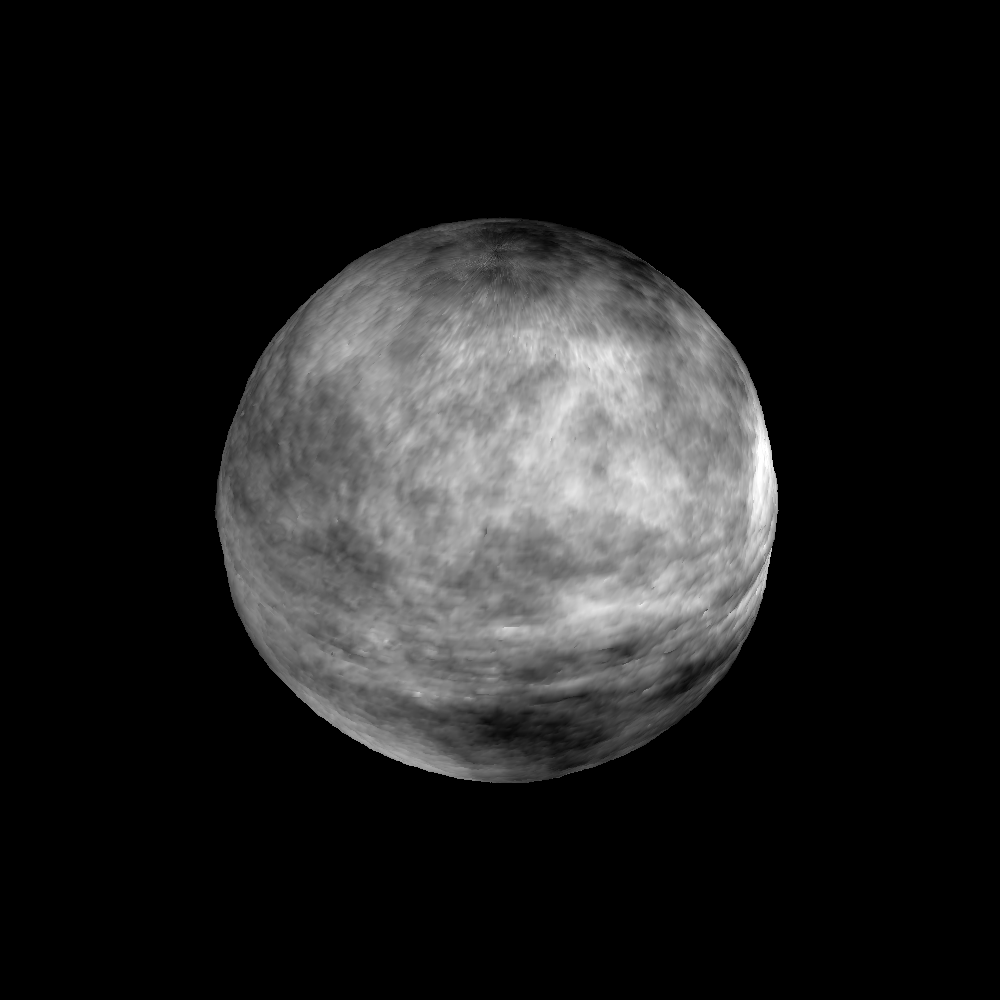

In [364]:
x = heights * np.sin(phi)*np.cos(theta)
y = heights * np.sin(phi)*np.sin(theta)
z = heights * np.cos(phi)

mlab.clf()
fig = mlab.figure(size=(1000, 1000), bgcolor=(0,0,0))

mlab.mesh(x, y, z, scalars=heights, colormap=rand_cmap, figure=fig)